## CMEMS Eddies

Work with eddy output produced from the OceanEddies software for CMEMS data. If you want to learn more about how the dataset was generated, check out this paper: https://www.nature.com/articles/sdata201528

---------

REQUIRED PACKAGES 


Shapely
- I use this package to check if points are in or out of polygons (eddy boundaries)
- https://shapely.readthedocs.io/en/stable/manual.html
- Install with code: conda install -c conda-forge shapely

Xarray & Netcdf4
- I use these packages to read the CMEMS sea level anomaly data that are in netCDF formate
- http://xarray.pydata.org/en/stable/, https://anaconda.org/anaconda/netcdf4
- Install with code: conda install -c anaconda xarray netcdf4

----------
Lexi Jones

Environment: CMEMS_eddies (on desktop), CMEMS_eddies_v2 (on laptop)

Date Created: 06/25/2021

Last Edited: 07/06/2021

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import csv

### Open the dataset

In [36]:
#eddy_dir = '/Users/lexijones/Documents/OceanEddies-master2/OceanEddiesOutput/CMEMS_NP_2000_to_2020/Data/'
eddy_dir = '/Users/lexijones/Dropbox (MIT)/Grad_School/2021_Summer_UROP/data/'

In [3]:
anti_eddy_data_2000,cyc_eddy_data_2000 = [],[] #set up two empty arrays to read in the data

#First I'm opening the anticyclonic dataset and reading the first decade of data into an array
with open(eddy_dir + 'anticyc_eddy_data_minage27_20000101_to_20191231.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    print('Reading anticyclonic eddy file...')
    
    i = 0
    for row in csv_reader:
        if i == 0:
            print(row) #this is just to check the header; there will be 'empty' columns because the boundary coords will take up many columns
        
        else:
            if i %100000 == 0: # This shows the progress of how many data points we've gone through; might take a minute
                print(i)

            if int(row[0][0:4])<2001: #Get only the first year of data so it is just easier to work with for now
                anti_eddy_data_2000.append(row)
        i += 1
        
        
# Now I'm just doing the same thing for the cyclonic eddy data
with open(eddy_dir + 'cyclonic_eddy_data_minage27_20000101_to_20191231.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    print('Reading cyclonic eddy file...')
    
    i = 0
    for row in csv_reader:
        if i == 0:
            print(row)
        
        else:
            if i %100000 == 0: 
                print(i)

            if int(row[0][0:4])<2001: 
                cyc_eddy_data_2000.append(row)
        i += 1

Reading anticyclonic eddy file...
['Date', 'Eddy ID', 'Age (days)', 'Area (km^2)', 'Amplitude (cm)', 'Translation Speed (m/s)', 'Boundary Coords', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
11

In [4]:
# Check how many data points we have (at least 28 per eddy because they must survive 4 weeks to be included)
print(len(anti_eddy_data_2000))
print(len(cyc_eddy_data_2000))

105545
105730


The CSV fills in empty columns with '' so that all rows are the same length, because different eddies will have different numbers of boundary coordinates. For now we will keep them in because numpy arrays are easier to work with when all of the rows/columns are the same length.

In [5]:
print(anti_eddy_data_2000[0]) #check what a single row looks like

['20000101', '2', '1', '13148.407936', '3.24411764705882', '1.42772140941889', '180.625', '38.875', '180.875', '38.875', '181.125', '38.875', '181.375', '38.875', '181.625', '38.875', '181.875', '38.875', '182.125', '39.125', '182.375', '39.375', '182.625', '39.375', '182.875', '39.375', '182.625', '39.375', '182.375', '39.625', '182.125', '39.625', '181.875', '39.375', '181.625', '39.375', '181.375', '39.375', '181.125', '39.375', '180.875', '39.125', '180.625', '38.875', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

In [9]:
# Convert the arrays into numpy arrays so they are easier to work with; might take a minute
anti_eddy_data_2000 = np.array(anti_eddy_data_2000)
cyc_eddy_data_2000 = np.array(cyc_eddy_data_2000)

In [10]:
#check number of unique eddy IDs
print(len(np.unique(anti_eddy_data_2000[:,1]))) 
print(len(np.unique(cyc_eddy_data_2000[:,1]))) 

1885
2019


### Check if a point is inside an eddy

In [11]:
#You can find the indices for the rows for a certain date by searching through the first column (index 0) of all of the rows
#Dates are of the form YYYYMMDD and are currently being read as strings

day_inds = np.where(anti_eddy_data_2000[:,0] == '20000321') 
day_inds

(array([  241,   665,  1062,  1293,  1540,  1627,  1926,  2222,  2438,
         2587,  2978,  3128,  3373,  3617,  3811,  4323,  4472,  4655,
         4801,  5113,  5628,  6032,  6420,  6522,  6811,  7532,  7811,
         9052,  9396,  9757, 10000, 10192, 10284, 10361, 10836, 11047,
        11391, 11544, 11791, 12249, 12432, 12614, 12784, 12902, 13028,
        13104, 13215, 13731, 13821, 14018, 14133, 14198, 14360, 14685,
        15127, 15308, 15370, 15487, 15622, 15694, 15754, 15917, 16087,
        16226, 16307, 16776, 16875, 17178, 17416, 17862, 17977, 18099,
        18149, 18311, 18432, 18511, 18646, 18763, 18821, 18910, 18966,
        19044, 19180, 19293, 19389, 19439, 19575, 19687, 19736, 19794,
        19882, 19940, 20259, 20302, 20381, 20537, 20641, 20689, 20768,
        20868, 20923, 21034, 21107, 21193, 21377, 21446, 21551, 21636,
        21807, 21910, 21947, 22120, 22157, 22246, 22282, 22348, 22495,
        22539, 22590, 22666, 22700, 22735, 22779, 22851, 22908, 22946,
      

In [12]:
#Grab just the coordinates for the eddy boundaries on this one day; coordinates are from column index 6 and on

day_eddy_bnds = anti_eddy_data_2000[day_inds,6:] 
day_eddy_bnds

array([[['187.125', '48.625', '187.375', ..., '', '', ''],
        ['195.875', '16.125', '196.125', ..., '', '', ''],
        ['203.125', '16.375', '203.375', ..., '', '', ''],
        ...,
        ['168.375', '42.375', '168.625', ..., '', '', ''],
        ['170.625', '16.625', '170.875', ..., '', '', ''],
        ['179.125', '25.375', '179.375', ..., '', '', '']]], dtype='<U18')

In [13]:
print(np.shape(day_eddy_bnds)) #after running the last step, we can see the array has an unnecessary dimension

(1, 307, 196)


In [14]:
day_eddy_bnds = np.squeeze(day_eddy_bnds) #remove the extra dimension with the np.squeeze function
print(np.shape(day_eddy_bnds))
day_eddy_bnds 

(307, 196)


array([['187.125', '48.625', '187.375', ..., '', '', ''],
       ['195.875', '16.125', '196.125', ..., '', '', ''],
       ['203.125', '16.375', '203.375', ..., '', '', ''],
       ...,
       ['168.375', '42.375', '168.625', ..., '', '', ''],
       ['170.625', '16.625', '170.875', ..., '', '', ''],
       ['179.125', '25.375', '179.375', ..., '', '', '']], dtype='<U18')

In [15]:
# Now let's remove the empty data
nan_removed_bnds = []
for coords in day_eddy_bnds: #iterate through the list of coords for each eddy
    nan_removed_bnds.append([float(x) for x in coords if x != '']) #remove all the empty values and convert them from strings to floats

print(nan_removed_bnds[0])

[187.125, 48.625, 187.375, 48.375, 187.625, 48.375, 187.875, 48.375, 188.125, 48.125, 188.375, 48.125, 188.625, 48.125, 188.875, 48.125, 189.125, 48.375, 189.375, 48.625, 189.375, 48.875, 189.125, 49.125, 189.125, 49.375, 188.875, 49.375, 188.625, 49.625, 188.375, 49.625, 188.125, 49.625, 187.875, 49.875, 187.625, 49.875, 187.375, 49.625, 187.375, 49.375, 187.125, 49.125, 187.125, 48.875, 187.125, 48.625]


In [16]:
#We can seperate the lon and lat values by grabbing every other coordinate; here we are just working with the first eddy
x_values = nan_removed_bnds[0][0::2]
y_values = nan_removed_bnds[0][1::2]

print(x_values)
print(y_values)

[187.125, 187.375, 187.625, 187.875, 188.125, 188.375, 188.625, 188.875, 189.125, 189.375, 189.375, 189.125, 189.125, 188.875, 188.625, 188.375, 188.125, 187.875, 187.625, 187.375, 187.375, 187.125, 187.125, 187.125]
[48.625, 48.375, 48.375, 48.375, 48.125, 48.125, 48.125, 48.125, 48.375, 48.625, 48.875, 49.125, 49.375, 49.375, 49.625, 49.625, 49.625, 49.875, 49.875, 49.625, 49.375, 49.125, 48.875, 48.625]


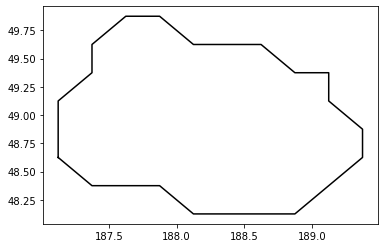

In [17]:
plt.plot(x_values,y_values,c='k'); #plot the first eddy's boundary points

In [18]:
#Reformat the data points to be read into the shapely Polygon function
# Some more info on this here at the Stack Overflow forum: https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
    
poly_pts = []

for pt in np.arange(0,len(x_values)): #iterate through each point of the polygon
    poly_pts.append((x_values[pt],y_values[pt])) #reformat with parentheses
print(poly_pts)

[(187.125, 48.625), (187.375, 48.375), (187.625, 48.375), (187.875, 48.375), (188.125, 48.125), (188.375, 48.125), (188.625, 48.125), (188.875, 48.125), (189.125, 48.375), (189.375, 48.625), (189.375, 48.875), (189.125, 49.125), (189.125, 49.375), (188.875, 49.375), (188.625, 49.625), (188.375, 49.625), (188.125, 49.625), (187.875, 49.875), (187.625, 49.875), (187.375, 49.625), (187.375, 49.375), (187.125, 49.125), (187.125, 48.875), (187.125, 48.625)]


In [19]:
#check if a given data point is inside the eddy
polygon = Polygon(poly_pts)
point = Point(188.5, 49.0)

print(polygon.contains(point)) #true means the point is in the eddy

True


In [20]:
polygon = Polygon(poly_pts)
point = Point(188.5, 50.0)

print(polygon.contains(point)) #here false means the point is not in the eddy

False


Let's put all of this code into a function called 'check_if_in_eddy' that we can use again and again.

In [21]:
def check_if_in_eddy(date,lon,lat,eddy_data):
    """
    Inputs
        date - Format YYYYMMDD
        lat - 10 to 70 (degrees north); latitude of the data point
        lon - input should be positive coordinates (110 to 250 degrees); longitude of the data point
        eddy_array - Name of the eddy dataset to look through (cyc or anti)
        
    Outputs
        0 if point is not in eddy, OR eddy ID if point is in an eddy
    """
    
    #Open .csv file with eddy data
    day_inds = np.where(eddy_data[:,0] == str(date)) #find all eddies from the requested date
    eddy_bnds = np.squeeze(eddy_data[day_inds,6:]) #get the eddy boundary coordinates & remove extraneous dimensions of the array
    eddy_ids = np.squeeze(eddy_data[day_inds,1]) #get the eddy ids
    
    #Iterate through the data for each eddy that is present on the requested date
    in_eddy = 0 #flag to determine if the point is in an eddy
    i = 0 #counter
    for eddy in eddy_bnds:
        bnds = [float(coord) for coord in eddy if str(coord) != ''] #Remove nan values from the eddy boundaries
        
        #Seperate the x & y values 
        x_values = bnds[0::2]
        y_values = bnds[1::2]
        
        #Check if the point is far away from the eddy we are checking right now, and if so, skip to the next eddy
        if lon > np.max(x_values) or lon < np.min(x_values) or lat > np.max(y_values) or lat < np.min(y_values):
            i += 1 #have to step up the counter here because the loop will skip the rest of the code here
            continue
        
        #If the point is close to the eddy, reformat the data so it is readable by the Polygon function
        poly_pts = [(x_values[pt],y_values[pt]) for pt in np.arange(0,len(x_values))]
        polygon = Polygon(poly_pts)
        data_pt = Point(lon,lat)
        
        if polygon.contains(data_pt):
            in_eddy = int(eddy_ids[i])
            break
                
        i += 1
    
    return in_eddy

Test this function with the point we just tested above. The function should output the ID of that eddy.

In [22]:
check_if_in_eddy(20000321,188.5,49.0,anti_eddy_data_2000)

22

In [23]:
result = check_if_in_eddy(20000321,188.5,50.0,anti_eddy_data_2000)
print(result)

0


Here is a function to plot an individual eddy on a given date.

In [24]:
def plot_individual_eddy(date,ID,eddy_data):
    """
    Inputs
        date - Format YYYYMMDD
        ID - Identifier number for the eddy
        eddy_array - Name of the eddy dataset to look through (cyc or anti)
        
    Outputs
        Plot of the eddy boundary
    """
    
    day_inds = np.where(eddy_data[:,0] == str(date)) #find all eddies from the requested date
    id_inds = np.where(eddy_data[:,1] == str(ID)) #find all the data points for the eddy with the requested ID
    final_ind = np.intersect1d(day_inds,id_inds) #find the single row for the eddy at that date
    
    eddy_bnds = np.squeeze(eddy_data[final_ind])[6:] #get the boundary points
    nan_removed_bnds = [float(coord) for coord in eddy_bnds if str(coord) != ''] #convert to floats and remove empty data
    
    #Split into longitude and latitude for the plot
    x_values = nan_removed_bnds[0::2]
    y_values = nan_removed_bnds[1::2]

    plt.plot(x_values,y_values,c='k'); #semi-colons here just take away the matplotlib text output above the plot
    plt.title('%s-%s-%s, Eddy ID %s'%(str(date)[4:6],str(date)[6:8],str(date)[0:4],ID)); 
    plt.xlabel('Longitude');
    plt.ylabel('Latitude');

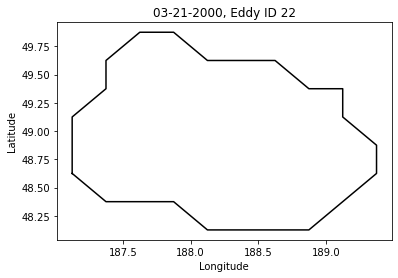

In [25]:
plot_individual_eddy(20000321,22,anti_eddy_data_2000)

Here I'm checking for some more of the ID's on 03/21/2000 to plot and test.

In [26]:
day_inds = np.where(anti_eddy_data_2000[:,0] == '20000321') 
eddy_ids = anti_eddy_data_2000[day_inds,1]
eddy_ids

array([['22', '69', '96', '103', '104', '107', '128', '129', '148',
        '149', '171', '178', '183', '184', '197', '209', '210', '223',
        '228', '280', '322', '331', '341', '343', '353', '404', '411',
        '454', '465', '526', '566', '632', '634', '637', '723', '736',
        '779', '783', '815', '905', '932', '965', '999', '1001', '1034',
        '1050', '1065', '1101', '1105', '1146', '1155', '1170', '1184',
        '1226', '1290', '1306', '1309', '1330', '1359', '1366', '1381',
        '1402', '1441', '1442', '1445', '1544', '1566', '1629', '1648',
        '1662', '1685', '1710', '1715', '1723', '1733', '1735', '1770',
        '1823', '1846', '1858', '1859', '1885', '1915', '1938', '1951',
        '1955', '1956', '2008', '2012', '2018', '2042', '2046', '2051',
        '2052', '2062', '2088', '2095', '2100', '2102', '2109', '2110',
        '2118', '2122', '2123', '2125', '2145', '2152', '2175', '2194',
        '2213', '2231', '2242', '2244', '2258', '2268', '2276', '2280'

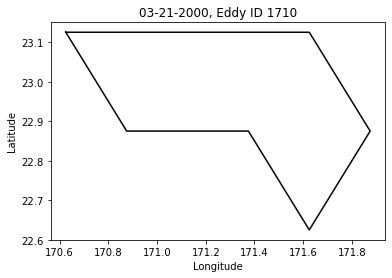

In [27]:
plot_individual_eddy(20000321,1710,anti_eddy_data_2000)

In [28]:
check_if_in_eddy(20000321,171.2,23.0,anti_eddy_data_2000)

1710

In [29]:
check_if_in_eddy(20000321,171.2,22.7,anti_eddy_data_2000)

0

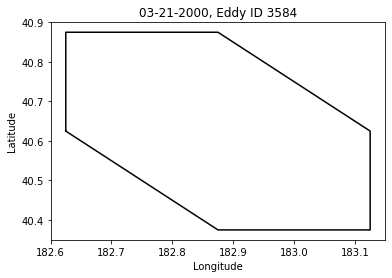

In [30]:
plot_individual_eddy(20000321,3584,anti_eddy_data_2000)

In [31]:
check_if_in_eddy(20000321,182.9,40.6,anti_eddy_data_2000)

3584

In [32]:
check_if_in_eddy(20000321,182.9,50.0,anti_eddy_data_2000)

0

### Visualize eddy field

Here we will plot all of the eddies for a requested date. I don't do it here but this is where you can use cartopy boundaries to provide context to the figure. 

In [33]:
def visualize_eddy_field(date,anti_eddy_data,cyc_eddy_data):
    """
    Input
        date - Format YYYYMMDD
        anti_eddy_data - array with data
        cyc_eddy_data - array with data
        
    Output
        Plot of eddy contours on a given date. This function can be used to plot eddy contours with other data as well.
    """

    anti_day_inds = np.where(anti_eddy_data[:,0] == str(date))
    cyc_day_inds = np.where(cyc_eddy_data[:,0] == str(date))
    
    anti_eddy_bnds = np.squeeze(anti_eddy_data[anti_day_inds,6:])
    cyc_eddy_bnds = np.squeeze(cyc_eddy_data[cyc_day_inds,6:])
    
    i = 0 #counter
    for bnds in anti_eddy_bnds:
        x_values = [float(coord) for coord in bnds[0::2] if str(coord) != '']
        y_values = [float(coord) for coord in bnds[1::2] if str(coord) != '']

        if i ==0:
            ax.plot(x_values,y_values,c='#991414',label='Anticyclonic Eddy') #create label for just the first eddy to feed into the legend
        else:
            ax.plot(x_values,y_values,c='#991414') #This color is produced via a hex code, check out https://htmlcolorcodes.com/
        i+=1
    
    j = 0 #counter
    for bnds in cyc_eddy_bnds:    
        x_values = [float(coord) for coord in bnds[0::2] if str(coord) != '']
        y_values = [float(coord) for coord in bnds[1::2] if str(coord) != '']
        
        if j ==0:
            ax.plot(x_values,y_values,c='#08088A',label='Cyclonic Eddy')
        else:
            ax.plot(x_values,y_values,c='#08088A') 
        j+=1
    
    # Create legend for cyclonic & anticyclonic
    ax.legend(loc='upper left', fontsize = 20)
        
    # Add labels and set font sizes    
    ax.set_title('%s-%s-%s North Pacific Mesoscale Eddy Field'%(str(date)[4:6],str(date)[6:8],str(date)[0:4]),fontsize=20)
    ax.set_xlabel('Longitude',fontsize=20)
    ax.set_ylabel('Latitude',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)


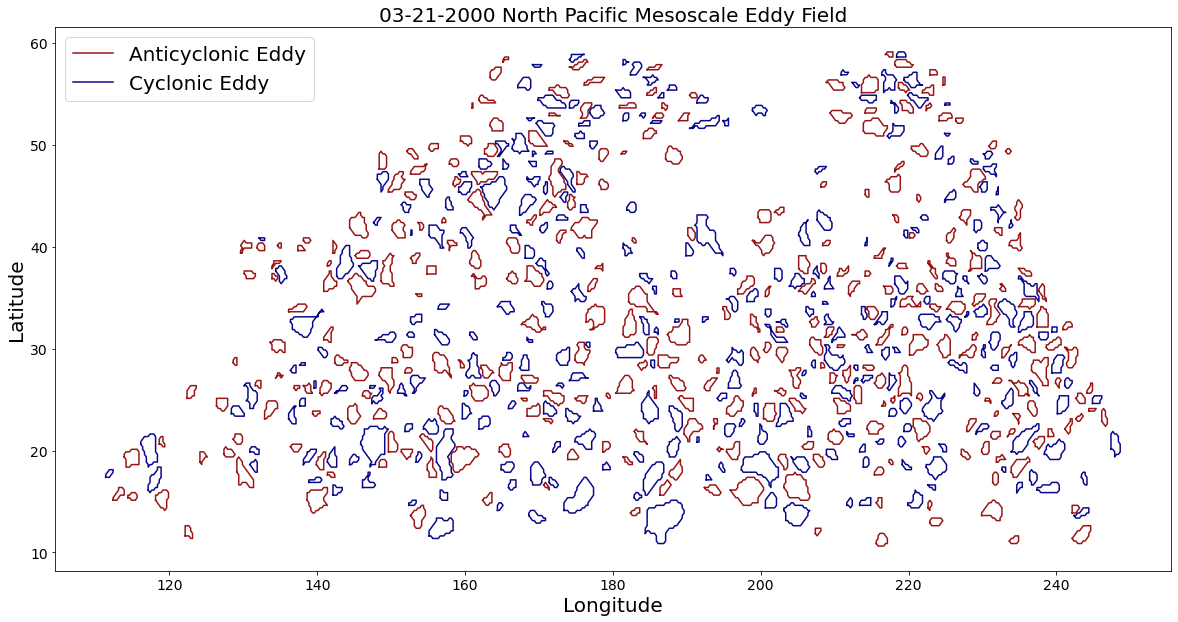

In [37]:
date = '20000321'

# Plot data
fig,ax = plt.subplots(1,1,figsize=(20,10))
visualize_eddy_field(date,anti_eddy_data_2000,cyc_eddy_data_2000)

Now let's plot these eddies on top of other data. You can get a few of the example .nc files from the Google Drive.

In [38]:
nc_filename = 'dt_global_allsat_phy_l4_20000321.nc'
ds = xr.open_dataset(eddy_dir + nc_filename)
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2000-03-21
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
Data variables:
    crs        int32 ...
    lat_bnds   (latitude, nv) float32 ...
    lon_bnds   (longitude, nv) float32 ...
    err        (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-03-21T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2000-03-21T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

This dataset is global, so I tested which indeces should be the bounds for the North Pacific.

In [48]:
print(ds.lat_bnds[400,0])
print(ds.lat_bnds[650,0])
print(ds.lon_bnds[450,0])
print(ds.lon_bnds[1000,0])

<xarray.DataArray 'lat_bnds' ()>
array(10., dtype=float32)
Coordinates:
    latitude  float32 10.12
    nv        int32 0
Attributes:
    comment:  latitude values at the north and south bounds of each pixel.
    units:    degrees_north
<xarray.DataArray 'lat_bnds' ()>
array(72.5, dtype=float32)
Coordinates:
    latitude  float32 72.62
    nv        int32 0
Attributes:
    comment:  latitude values at the north and south bounds of each pixel.
    units:    degrees_north
<xarray.DataArray 'lon_bnds' ()>
array(112.5, dtype=float32)
Coordinates:
    longitude  float32 112.6
    nv         int32 0
Attributes:
    comment:  longitude values at the west and east bounds of each pixel.
    units:    degrees_east
<xarray.DataArray 'lon_bnds' ()>
array(250., dtype=float32)
Coordinates:
    longitude  float32 250.1
    nv         int32 0
Attributes:
    comment:  longitude values at the west and east bounds of each pixel.
    units:    degrees_east


/var/folders/3k/1t8n80h50719q9vxr497v8l40000gn/T/ipykernel_81823/574520364.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  background_plot = ax.pcolormesh(ds.lon_bnds[lon1:lon2,0],ds.lat_bnds[lat1:lat2,0],


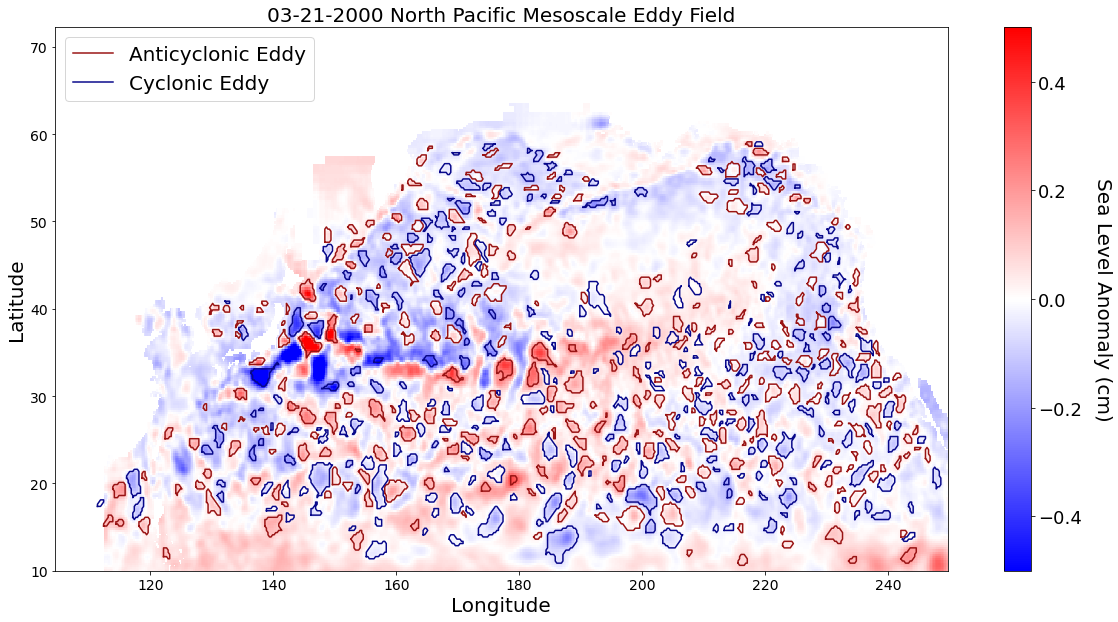

In [49]:
fig,ax = plt.subplots(1,1,figsize=(20,10))

lat1,lat2 = 400,650
lon1,lon2 = 450,1000

#Background SLA
background_plot = ax.pcolormesh(ds.lon_bnds[lon1:lon2,0],ds.lat_bnds[lat1:lat2,0],
                                    ds.sla[0,lat1:lat2,lon1:lon2],cmap='bwr',vmin=-0.5, vmax=0.5)

#Add a colorbar with label
cbar = plt.colorbar(background_plot)
cbar.ax.tick_params(labelsize=18)
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('Sea Level Anomaly (cm)', rotation=270, fontsize=20)

#Plot eddy boundaries
visualize_eddy_field(date,anti_eddy_data_2000,cyc_eddy_data_2000)


### Co-locate data with eddies
I generate random data points here as my pseudo CO2 measurements.

In [42]:
import random

In [43]:
def generate_random_data(start, end, num):
    res = []
    for j in range(num):
        res.append(random.randint(start, end))
    return res

In [44]:
rand_x = generate_random_data(140,220,400)
rand_y = generate_random_data(20,40,400)
rand_values = generate_random_data(400,450,400)

/var/folders/3k/1t8n80h50719q9vxr497v8l40000gn/T/ipykernel_81823/3022797275.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  background_plot = ax.pcolormesh(ds.lon_bnds[lon1:lon2,0],ds.lat_bnds[lat1:lat2,0],


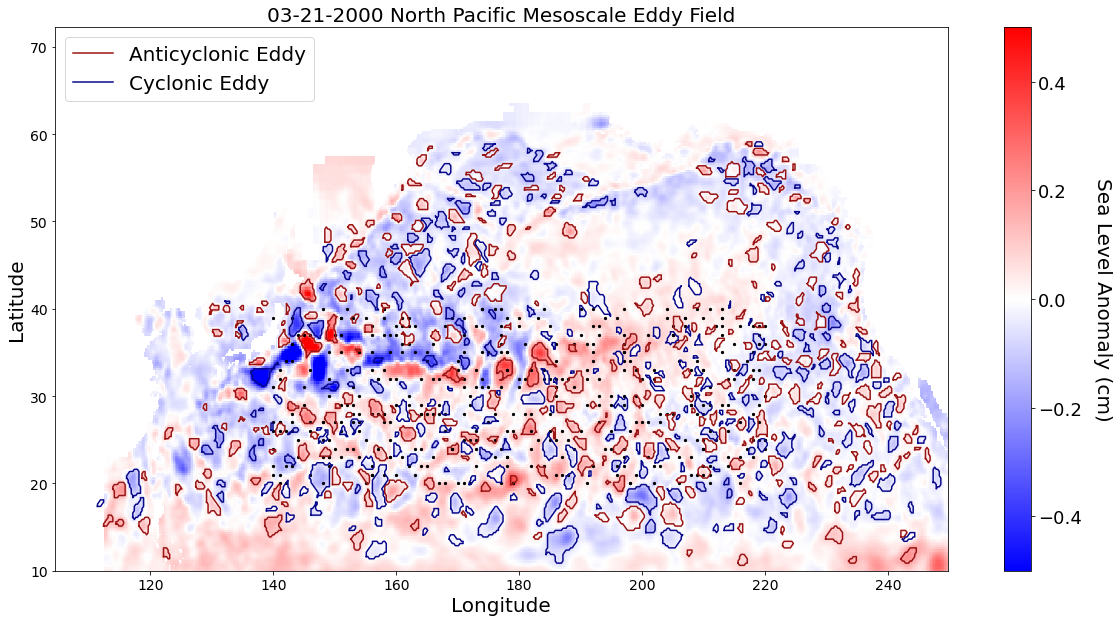

In [51]:
fig,ax = plt.subplots(1,1,figsize=(20,10))

#Background SLA 
background_plot = ax.pcolormesh(ds.lon_bnds[lon1:lon2,0],ds.lat_bnds[lat1:lat2,0],
                                    ds.sla[0,lat1:lat2,lon1:lon2],cmap='bwr',vmin=-0.5, vmax=0.5)

#Add a colorbar with label
cbar = plt.colorbar(background_plot)
cbar.ax.tick_params(labelsize=18)
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('Sea Level Anomaly (cm)', rotation=270, fontsize=20)

#Plot eddy boundaries
visualize_eddy_field(date,anti_eddy_data_2000,cyc_eddy_data_2000)

#Plot data points on top in black
ax.scatter(rand_x,rand_y,c='k',s=5)

Let's look at the relationships between the pCO2 data and the eddy attributes.

In [52]:
#Create an array that indicates if the data points are in an eddy or not.
anti_rand_eddies,cyc_rand_eddies = [],[]

for i in np.arange(0,len(rand_x)):
    anti_rand_eddies.append(check_if_in_eddy(20000321,rand_x[i],rand_y[i],anti_eddy_data_2000)) #check the anticyc eddy dataset
    cyc_rand_eddies.append(check_if_in_eddy(20000321,rand_x[i],rand_y[i],cyc_eddy_data_2000)) #check the cyclonic eddy dataset
    
#Convert to numpy arrays
anti_rand_eddies = np.array(anti_rand_eddies)
cyc_rand_eddies = np.array(cyc_rand_eddies) 

print(anti_rand_eddies)
print(cyc_rand_eddies)

[3155    0    0    0    0 1146    0    0    0    0    0    0    0    0
    0    0 2018    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 3469
    0    0 2417    0    0  634    0    0    0 3574    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 3281    0    0    0    0    0    0    0    0    0    0    0 2915
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 2596    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 3483    0 2596    0    0    0 3111    0    0    0    0    0
 3155    0    0    0 2535    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 3002    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [69]:
pco2_in_anti_inds = np.squeeze(np.where(anti_rand_eddies != 0))
pco2_in_cyc_inds = np.squeeze(np.where(cyc_rand_eddies != 0))

In [70]:
#Get eddy dataset info EXCEPT for the boundaries from this day for both datasets
anti_day_inds = np.where(anti_eddy_data_2000[:,0] == '20000321') 
anti_day_eddy_data = np.squeeze(anti_eddy_data_2000[anti_day_inds,:6]) 

cyc_day_inds = np.where(cyc_eddy_data_2000[:,0] == '20000321') 
cyc_day_eddy_data = np.squeeze(cyc_eddy_data_2000[cyc_day_inds,:6]) 

In [73]:
print(rand_values[0])

415


In [104]:
#Initialize empty arrays to add data to later
anti_co2_values, anti_eddy_ages, anti_eddy_sizes, anti_eddy_amps, anti_eddy_speeds = [],[],[],[],[]
cyc_co2_values, cyc_eddy_ages, cyc_eddy_sizes, cyc_eddy_amps, cyc_eddy_speeds = [],[],[],[],[]

for ind in pco2_in_anti_inds: #iterate through all of the co2 data points in an anticyclonic eddy        
    
    #info from the point data    
    eddy_id = anti_rand_eddies[ind]    
    anti_co2_values.append(rand_values[ind])    
    
    #info from the eddy dataset
    eddy_ind = np.squeeze(np.where(anti_day_eddy_data[:,1] == str(eddy_id))) #get the row in the CSV with the data for this eddy on this day
        
    anti_eddy_ages.append(float(anti_day_eddy_data[eddy_ind,2])) #add the eddy age from the CSV
    anti_eddy_sizes.append(float(anti_day_eddy_data[eddy_ind,3])) #add the eddy size from the CSV
    anti_eddy_amps.append(float(anti_day_eddy_data[eddy_ind,4])) #add the eddy amplitude from the CSV
    anti_eddy_speeds.append(float(anti_day_eddy_data[eddy_ind,5])) #add the eddy translation speed from the CSV
        
for ind in pco2_in_cyc_inds: #now iterate through all of the co2 data points in a cyclonic eddy  
    
    #info from the point data    
    eddy_id = cyc_rand_eddies[ind]
    cyc_co2_values.append(rand_values[ind])    
    
    #info from the eddy dataset
    eddy_ind = np.squeeze(np.where(cyc_day_eddy_data[:,1] == str(eddy_id))) #get the row in the CSV with the data for this eddy on this day\
        
    cyc_eddy_ages.append(float(cyc_day_eddy_data[eddy_ind,2])) #add the eddy age from the CSV
    cyc_eddy_sizes.append(float(cyc_day_eddy_data[eddy_ind,3])) #add the eddy size from the CSV
    cyc_eddy_amps.append(float(cyc_day_eddy_data[eddy_ind,4])) #add the eddy amplitude from the CSV
    cyc_eddy_speeds.append(float(cyc_day_eddy_data[eddy_ind,5])) #add the eddy translation speed from the CSV

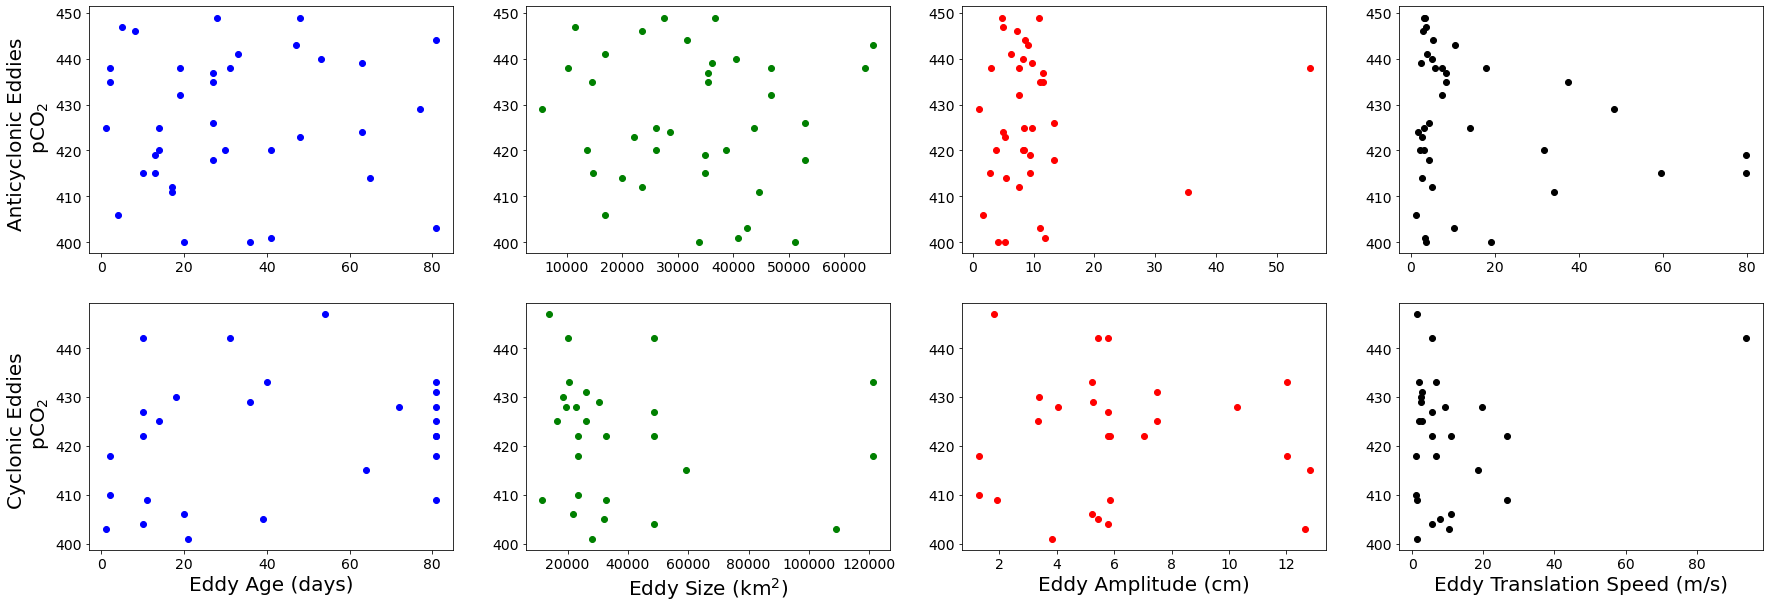

In [118]:
fig,ax = plt.subplots(2,4,figsize=(30,10))

# Plot the anticyclonic relationships
ax[0,0].scatter(anti_eddy_ages,anti_co2_values,c='b')
ax[0,1].scatter(anti_eddy_sizes,anti_co2_values,c='g')
ax[0,2].scatter(anti_eddy_amps,anti_co2_values,c='r')
ax[0,3].scatter(anti_eddy_speeds,anti_co2_values,c='k')

# Plot the cyclonic relationships
ax[1,0].scatter(cyc_eddy_ages,cyc_co2_values,c='b')
ax[1,1].scatter(cyc_eddy_sizes,cyc_co2_values,c='g')
ax[1,2].scatter(cyc_eddy_amps,cyc_co2_values,c='r')
ax[1,3].scatter(cyc_eddy_speeds,cyc_co2_values,c='k')

# Add labels and set font sizes
x_labels = ['Eddy Age (days)', 'Eddy Size (km$^2$)', 'Eddy Amplitude (cm)', 'Eddy Translation Speed (m/s)']
ax[1,0].set_xlabel(x_labels[0],fontsize=20)
ax[1,1].set_xlabel(x_labels[1],fontsize=20)
ax[1,2].set_xlabel(x_labels[2],fontsize=20)
ax[1,3].set_xlabel(x_labels[3],fontsize=20)

ax[0,0].set_ylabel('Anticyclonic Eddies \n pCO$_2$',fontsize=20)
ax[1,0].set_ylabel('Cyclonic Eddies \n pCO$_2$',fontsize=20)

for i in np.arange(0,2):
    for j in np.arange(0,4):
        ax[i,j].tick_params(axis='both', which='major', labelsize=14) #changes the size of the number labels

From here you can try some statistical analysis like a linear regression: https://realpython.com/linear-regression-in-python/